In [2]:
import os
import sys
import math
import torch
import sacrebleu 
import numpy as np
import pandas as pd
import code_bert_score
from radon.raw import analyze
import matplotlib.pyplot as plt
from radon.metrics import mi_visit
from radon.complexity import cc_visit
from transformers import pipeline, AutoTokenizer, AutoModel

In [3]:
path = './csv_files/lab_2/final_files.csv'

file_df = pd.read_csv(path)
display(file_df.tail(5))

,commit_hash,commit_msg,filename,source_code_before,source_code_after,diff,llm_msg,rec_msg,llm_inference
1321,c799b8167a13416833ad3b4f3298261a477e826f,docs: fix dead links to kenreitz.org,docs\dev\contributing.rst,.. _contributing:\n\nContributor's Guide\n====...,.. _contributing:\n\nContributor's Guide\n====...,"@@ -34,7 +34,7 @@ including reporting bugs or ...",add missing docs for kenneth reitz,add more info about kenneth reitz project,fix link to kennethreitz.org
1322,c799b8167a13416833ad3b4f3298261a477e826f,docs: fix dead links to kenreitz.org,docs\user\advanced.rst,.. _advanced:\n\nAdvanced Usage\n=============...,.. _advanced:\n\nAdvanced Usage\n=============...,"@@ -1053,7 +1053,7 @@ backoff, within a Reques...",add missing docs for kenneth reitz,add more info about kenneth reitz project,fix broken links to kennethreitz.org
1323,7bc45877a86192af77645e156eb3744f95b47dae,Add new test to check netrc auth leak (#6962)\...,tests\test_requests.py,"""""""Tests for Requests.""""""\n\nimport collection...","""""""Tests for Requests.""""""\n\nimport collection...","@@ -7,6 +7,7 @@ import json\n import os\n impo...",add test for http digest auth leak,add test for http digest auth leak,add test for http digest auth leak
1324,3f07f990ac74f1e1691ba17ef8c14007f05846ab,Fix typo in documentation for verify,src\requests\adapters.py,"""""""\nrequests.adapters\n~~~~~~~~~~~~~~~~~\n\nT...","""""""\nrequests.adapters\n~~~~~~~~~~~~~~~~~\n\nT...","@@ -410,7 +410,7 @@ class HTTPAdapter(BaseAdap...",fix typo in http_adapter.py,update http_adapter.py,fix typo in http_adapter.py
1325,8ff173b186f135670879db9fbe1e68a6b5209c89,Clarify error description in cloning instructi...,README.md,"# Requests\n\n**Requests** is a simple, yet el...","# Requests\n\n**Requests** is a simple, yet el...","@@ -60,7 +60,7 @@ Requests is ready for the de...",clarify error description,clarify error description,clarify error description


In [23]:
n_commits = file_df["commit_hash"].nunique()
n_files = file_df.shape[0]

file_types = file_df["filename"].apply(lambda x: x.split(".")[-1]).value_counts()

print("Number of commits: ", n_commits)
print("Number of modified files: ", n_files)
print("Number of modified files per commit: ", n_files/n_commits)
print(file_types)

Number of commits:  870
Number of modified files:  1326
Number of modified files per commit:  1.5241379310344827
filename
py           958
rst          236
html          32
md            29
Makefile      14
yml           14
txt            9
AUTHORS        6
css            5
in             4
ini            4
lock           3
Pipfile        3
gitignore      2
HACKING        1
NOTICE         1
json           1
js             1
cfg            1
yaml           1
cnf            1
Name: count, dtype: int64


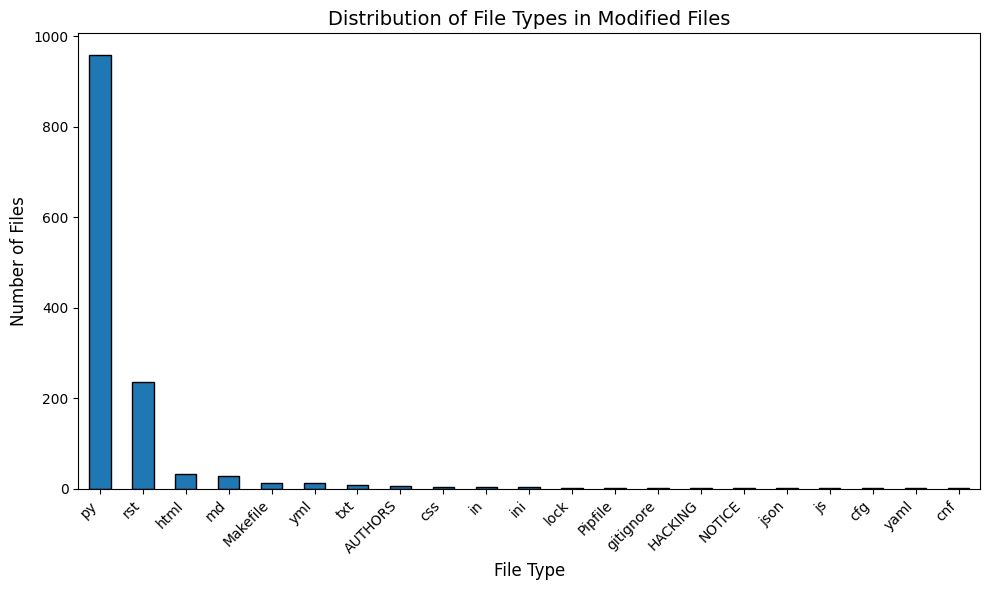

In [25]:
plt.figure(figsize=(10,6))
file_types.plot(kind="bar", edgecolor="black")

plt.title("Distribution of File Types in Modified Files", fontsize=14)
plt.xlabel("File Type", fontsize=12)
plt.ylabel("Number of Files", fontsize=12)
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.savefig("lab3_plots/barplot_file_types.png")
plt.show()

{'add': 740,
 'fix': 414,
 'update': 97,
 'improve': 43,
 'remove': 4,
 'revert': 3,
 'use': 3,
 'parametrize': 3,
 'ignore': 2,
 'clarify': 2,
 'allow': 2,
 'set': 2,
 'fix:': 2,
 'check': 1,
 'reset': 1,
 'raise': 1,
 'chunked': 1,
 'switch': 1,
 'disable': 1,
 'cache': 1,
 'close': 1,
 'prefer': 1}

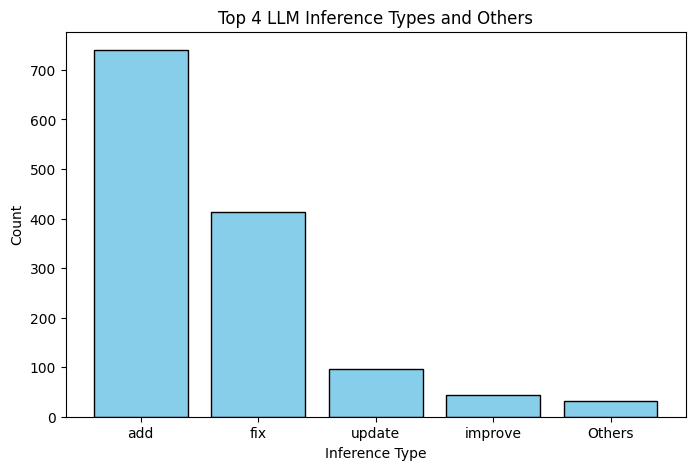

In [26]:
# Count inference types
llm_inferences = file_df['llm_inference'].dropna().astype(str)
all_types = {}

for inf in llm_inferences:
    key = inf.split()[0]
    all_types[key] = all_types.get(key, 0) + 1

sorted_types = dict(sorted(all_types.items(), key=lambda x: x[1], reverse=True))
display(sorted_types)

# Top 4 + "Others"
top4 = dict(list(sorted_types.items())[:4])
others_count = sum(list(sorted_types.values())[4:])
if others_count > 0:
    top4["Others"] = others_count

# Bar plot
plt.figure(figsize=(8, 5))
plt.bar(top4.keys(), top4.values(), color="skyblue", edgecolor="black")
plt.title("Top 4 LLM Inference Types and Others")
plt.ylabel("Count")
plt.xlabel("Inference Type")
plt.savefig("lab3_plots/barplot_inference_distribution.png")
plt.show()


In [31]:
def analyze_code(code):
    if not code:
        # print("Non code")
        # print(code)
        # print("--------------------------------")
        l = 0
        for i in range(len(code)):
            if code[i] == '\n':
                l += 1
        return (100, 0, l)
    try:
        mi = mi_visit(code, False)
        cc_objects = cc_visit(code)
        total_cc = sum(getattr(c, 'complexity', 0) for c in cc_objects)
        raw = analyze(code)
        loc = getattr(raw, 'loc', None)
        return (mi, int(total_cc) if total_cc is not None else None, int(loc) if loc is not None else None)
    except Exception:
        # print("Exception in code:")
        # print(code)
        # print("--------------------------------")
        return (None, None, None)

In [ ]:
file_df["MI_Change"] = None
file_df["CC_Change"] = None
file_df["LOC_Change"] = None

for idx, row in file_df.iterrows():
    if (row["filename"].split(".")[-1] != "py"):
        continue
    old_code = row["source_code_before"]
    new_code = row["source_code_after"]

    old_mi, old_cc, old_loc = analyze_code(old_code)
    new_mi, new_cc, new_loc = analyze_code(new_code)

    if old_mi is not None and new_mi is not None:
        mi_change = new_mi - old_mi
    else:
        mi_change = None

    if old_cc is not None and new_cc is not None:
        cc_change = new_cc - old_cc
    else:
        cc_change = None

    if old_loc is not None and new_loc is not None:
        loc_change = new_loc - old_loc
    else:
        loc_change = None

    file_df.at[idx, "MI_Change"] = mi_change
    file_df.at[idx, "CC_Change"] = cc_change
    file_df.at[idx, "LOC_Change"] = loc_change
    if idx == 10:
        break

display(file_df.head(10))
file_df.to_csv('./csv_files/lab_3/final_files_with_metrics.csv', index=False)
# file_df.to_csv('final_files_with_metrics.csv', index=False)


,commit_hash,commit_msg,filename,source_code_before,source_code_after,diff,llm_msg,rec_msg,llm_inference,MI_Change,CC_Change,LOC_Change
0,32cc197a81502c30715c9e164006dce6debcd1bf,fixes,requests\core.py,"# -*- coding: utf-8 -*-\n\n""""""\n requests.c...","# -*- coding: utf-8 -*-\n\n""""""\n requests.c...","@@ -13,8 +13,8 @@\n import httplib\n import ur...",add missing docstrings,add missing docstrings,add missing docstrings,-6.625436,1,40
1,3c32045da05cda554e65d3b943bb1128b2482c7f,FIXED,requests\core.py,"# -*- coding: utf-8 -*-\n\n""""""\n requests.c...","# -*- coding: utf-8 -*-\n\n""""""\n requests.c...","@@ -95,7 +95,7 @@ class Request(object):\n \t\...",add missing docstrings,add missing docstrings,add missing docstrings,-4.097534,1,-10
2,7de5726a812c5ae2cb8204e2974b62ca2750c9d0,log 405 issue,TODO.rst,NaN,TODO\n====\n\n* Fix 405 Exceptions,"@@ -0,0 +1,4 @@\n+TODO\n+====\n+\n+* Fix 405 E...",add comment,add missing comment,add comment,None,None,None
3,8cca789ba5df5d31f3c923001ee6dc9fcf7f1b1b,Fix it,README.rst,Requests: The Simple (e.g. usable) HTTP Module...,Requests: The Simple (e.g. usable) HTTP Module...,"@@ -71,19 +71,15 @@ API\n **Requests:**\n ...",add missing docs to api docs,add missing docs to api docs,add missing docs to api docs,None,None,None
4,8fd480df3fc0665c90ed9e9c18d0ca4eeab349bd,Fix NameError in example,README.rst,Requests: The Simple (e.g. usable) HTTP Module...,Requests: The Simple (e.g. usable) HTTP Module...,"@@ -1,22 +1,6 @@\n Requests: The Simple (e.g. ...",add more examples to http module names,add more examples to http module names,add more examples to http module names,None,None,None
5,4c8b428bbd3800cafa0e3764512eb719f67315f0,except clause fix for python3,requests\core.py,"# -*- coding: utf-8 -*-\n\n""""""\n requests.c...","# -*- coding: utf-8 -*-\n\n""""""\n requests.c...","@@ -141,7 +141,7 @@ class Request(object):\n \...",add missing docstrings,add missing docstrings in docstrings.py,add missing docstrings,None,None,None
6,10280c697dcfd3d334f1c9c381a11c324bb550bc,Handles request in event of HTTPError. Fixes I...,requests\core.py,"# -*- coding: utf-8 -*-\n\n""""""\n requests.c...","# -*- coding: utf-8 -*-\n\n""""""\n requests.c...","@@ -99,9 +99,17 @@ class Request(object):\n \t...","fix issue #299, 9 +99,17 and fix issue #299, 9...","fix issue #299, 9 +99,17","fix issue #299, 9 +99,17",0.296703,-1,-1
7,16e5119b2ad8be05673b5f8762cd71edaa0cd882,fixed gevent problem,requests\core.py,"# -*- coding: utf-8 -*-\n\n""""""\n requests.c...","# -*- coding: utf-8 -*-\n\n""""""\n requests.c...","@@ -103,23 +103,27 @@ class Request(object):\n...",fix bug in request class,fix bug in request class,fix bug in request class,-0.73776,2,4
8,397bd4b67688fe8b35b5c17a6f1d6f43ab076c18,spelling error,requests\core.py,"# -*- coding: utf-8 -*-\n\n""""""\n requests.c...","# -*- coding: utf-8 -*-\n\n""""""\n requests.c...","@@ -93,7 +93,7 @@ class Request(object):\n \t\...",add missing url check to request class,add missing url check to request class,add missing url check to request class,0.0,0,1
9,a5517960ea63728d3d8cb5c761a13b749575b3c9,history indent fix for rest/pypi,HISTORY.rst,History\n-------\n\n0.2.3 (2011-02-15)\n++++++...,History\n-------\n\n0.2.3 (2011-02-15)\n++++++...,"@@ -5,10 +5,10 @@ History\n ++++++++++++++++++...",add missing comments,add missing missing indentation,add missing indentation,None,None,None


In [33]:
device_idx = 0 if torch.cuda.is_available() else -1
print("pipeline device index:", device_idx)

def bert_score(a, b):
    if a is None or b is None:
        return 0.0
    if pd.isna(a) or pd.isna(b):
        return 0.0
    r, p, f1, f3 = code_bert_score.score(cands=[a], refs=[b], lang='python')
    return f1.item()
    

def bleu_score(a, b):
    if a is None or b is None:
        return 0.0
    try:
        bleu = sacrebleu.corpus_bleu([b], [[a]])
        return bleu.score
    except Exception:
        return 0.0


pipeline device index: 0


In [ ]:
file_df["Semantic Similarity"] = None
file_df["Token Similarity"] = None


for idx, row in file_df.iterrows():
    old_code = row["source_code_before"]
    new_code = row["source_code_after"]
    tok_sim = bleu_score(old_code, new_code)
    sem_sim = bert_score(old_code, new_code)
    file_df.at[idx, "Semantic Similarity"] = sem_sim
    file_df.at[idx, "Token Similarity"] = tok_sim
    if idx % 100 == 0:
        print(f"Processed {idx} rows")

display(file_df.head(10))
file_df.to_csv('./csv_files/lab_3/final_files_with_metrics_and_similarities.csv', index=False)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,commit_hash,commit_msg,filename,source_code_before,source_code_after,diff,llm_msg,rec_msg,llm_inference,MI_Change,CC_Change,LOC_Change,Semantic Similarity,Token Similarity,Token Class,Semantic Class,Classes Agree
0,32cc197a81502c30715c9e164006dce6debcd1bf,fixes,requests\core.py,"# -*- coding: utf-8 -*-\n\n""""""\n requests.c...","# -*- coding: utf-8 -*-\n\n""""""\n requests.c...","@@ -13,8 +13,8 @@\n import httplib\n import ur...",add missing docstrings,add missing docstrings,add missing docstrings,-6.625436,1.0,40.0,0.945943,78.522811,Major,Major,YES
1,3c32045da05cda554e65d3b943bb1128b2482c7f,FIXED,requests\core.py,"# -*- coding: utf-8 -*-\n\n""""""\n requests.c...","# -*- coding: utf-8 -*-\n\n""""""\n requests.c...","@@ -95,7 +95,7 @@ class Request(object):\n \t\...",add missing docstrings,add missing docstrings,add missing docstrings,-4.097534,1.0,-10.0,0.965500,92.442857,Major,Major,YES
2,7de5726a812c5ae2cb8204e2974b62ca2750c9d0,log 405 issue,TODO.rst,NaN,TODO\n====\n\n* Fix 405 Exceptions,"@@ -0,0 +1,4 @@\n+TODO\n+====\n+\n+* Fix 405 E...",add comment,add missing comment,add comment,NaN,NaN,NaN,0.000000,0.000000,Major,Major,YES
3,8cca789ba5df5d31f3c923001ee6dc9fcf7f1b1b,Fix it,README.rst,Requests: The Simple (e.g. usable) HTTP Module...,Requests: The Simple (e.g. usable) HTTP Module...,"@@ -71,19 +71,15 @@ API\n **Requests:**\n ...",add missing docs to api docs,add missing docs to api docs,add missing docs to api docs,NaN,NaN,NaN,0.990128,97.289484,Minor,Minor,YES
4,8fd480df3fc0665c90ed9e9c18d0ca4eeab349bd,Fix NameError in example,README.rst,Requests: The Simple (e.g. usable) HTTP Module...,Requests: The Simple (e.g. usable) HTTP Module...,"@@ -1,22 +1,6 @@\n Requests: The Simple (e.g. ...",add more examples to http module names,add more examples to http module names,add more examples to http module names,NaN,NaN,NaN,0.903731,62.923963,Major,Major,YES
5,4c8b428bbd3800cafa0e3764512eb719f67315f0,except clause fix for python3,requests\core.py,"# -*- coding: utf-8 -*-\n\n""""""\n requests.c...","# -*- coding: utf-8 -*-\n\n""""""\n requests.c...","@@ -141,7 +141,7 @@ class Request(object):\n \...",add missing docstrings,add missing docstrings in docstrings.py,add missing docstrings,NaN,NaN,NaN,0.996423,99.552574,Minor,Minor,YES
6,10280c697dcfd3d334f1c9c381a11c324bb550bc,Handles request in event of HTTPError. Fixes I...,requests\core.py,"# -*- coding: utf-8 -*-\n\n""""""\n requests.c...","# -*- coding: utf-8 -*-\n\n""""""\n requests.c...","@@ -99,9 +99,17 @@ class Request(object):\n \t...","fix issue #299, 9 +99,17 and fix issue #299, 9...","fix issue #299, 9 +99,17","fix issue #299, 9 +99,17",0.296703,-1.0,-1.0,0.962397,95.399458,Minor,Major,NO
7,16e5119b2ad8be05673b5f8762cd71edaa0cd882,fixed gevent problem,requests\core.py,"# -*- coding: utf-8 -*-\n\n""""""\n requests.c...","# -*- coding: utf-8 -*-\n\n""""""\n requests.c...","@@ -103,23 +103,27 @@ class Request(object):\n...",fix bug in request class,fix bug in request class,fix bug in request class,-0.737760,2.0,4.0,0.979252,99.401173,Minor,Major,NO
8,397bd4b67688fe8b35b5c17a6f1d6f43ab076c18,spelling error,requests\core.py,"# -*- coding: utf-8 -*-\n\n""""""\n requests.c...","# -*- coding: utf-8 -*-\n\n""""""\n requests.c...","@@ -93,7 +93,7 @@ class Request(object):\n \t\...",add missing url check to request class,add missing url check to request class,add missing url check to request class,0.000000,0.0,1.0,0.997719,99.910225,Minor,Minor,YES
9,a5517960ea63728d3d8cb5c761a13b749575b3c9,history indent fix for rest/pypi,HISTORY.rst,History\n-------\n\n0.2.3 (2011-02-15)\n++++++...,History\n-------\n\n0.2.3 (2011-02-15)\n++++++...,"@@ -5,10 +5,10 @@ History\n ++++++++++++++++++...",add missing comments,add missing missing indentation,add missing indentation,NaN,NaN,NaN,0.992701,100.000000,Minor,Minor,YES


In [20]:
file_df = pd.read_csv('csv_files/lab_3/final_files_with_metrics_and_similarities.csv')
tok_sim_threshold = 80
sem_sim_threshold = 0.9
print("Top 10% threshold for token similarity:", tok_sim_threshold)
print("Top 10% threshold for semantic similarity:", sem_sim_threshold)

file_df["Token Class"] = "Minor"
file_df["Semantic Class"] = "Minor"
file_df["Classes Agree"] = "NO"

file_df.loc[file_df["Token Similarity"] < tok_sim_threshold, "Token Class"] = "Major"
file_df.loc[file_df["Semantic Similarity"] < sem_sim_threshold, "Semantic Class"] = "Major"
file_df.loc[file_df["Token Class"]==file_df["Semantic Class"], "Classes Agree"] = "YES"
file_df.to_csv('csv_files/lab_3/complete_files.csv', index=False)

print(file_df.columns)
display(file_df.head(5))

Top 10% threshold for token similarity: 80
Top 10% threshold for semantic similarity: 0.9
Index(['commit_hash', 'commit_msg', 'filename', 'source_code_before',
       'source_code_after', 'diff', 'llm_msg', 'rec_msg', 'llm_inference',
       'MI_Change', 'CC_Change', 'LOC_Change', 'Semantic Similarity',
       'Token Similarity', 'Token Class', 'Semantic Class', 'Classes Agree'],
      dtype='object')


,commit_hash,commit_msg,filename,source_code_before,source_code_after,diff,llm_msg,rec_msg,llm_inference,MI_Change,CC_Change,LOC_Change,Semantic Similarity,Token Similarity,Token Class,Semantic Class,Classes Agree
0,32cc197a81502c30715c9e164006dce6debcd1bf,fixes,requests\core.py,"# -*- coding: utf-8 -*-\n\n""""""\n requests.c...","# -*- coding: utf-8 -*-\n\n""""""\n requests.c...","@@ -13,8 +13,8 @@\n import httplib\n import ur...",add missing docstrings,add missing docstrings,add missing docstrings,-6.625436,1.0,40.0,0.945943,78.522811,Major,Minor,NO
1,3c32045da05cda554e65d3b943bb1128b2482c7f,FIXED,requests\core.py,"# -*- coding: utf-8 -*-\n\n""""""\n requests.c...","# -*- coding: utf-8 -*-\n\n""""""\n requests.c...","@@ -95,7 +95,7 @@ class Request(object):\n \t\...",add missing docstrings,add missing docstrings,add missing docstrings,-4.097534,1.0,-10.0,0.965500,92.442857,Minor,Minor,YES
2,7de5726a812c5ae2cb8204e2974b62ca2750c9d0,log 405 issue,TODO.rst,NaN,TODO\n====\n\n* Fix 405 Exceptions,"@@ -0,0 +1,4 @@\n+TODO\n+====\n+\n+* Fix 405 E...",add comment,add missing comment,add comment,NaN,NaN,NaN,0.000000,0.000000,Major,Major,YES
3,8cca789ba5df5d31f3c923001ee6dc9fcf7f1b1b,Fix it,README.rst,Requests: The Simple (e.g. usable) HTTP Module...,Requests: The Simple (e.g. usable) HTTP Module...,"@@ -71,19 +71,15 @@ API\n **Requests:**\n ...",add missing docs to api docs,add missing docs to api docs,add missing docs to api docs,NaN,NaN,NaN,0.990128,97.289484,Minor,Minor,YES
4,8fd480df3fc0665c90ed9e9c18d0ca4eeab349bd,Fix NameError in example,README.rst,Requests: The Simple (e.g. usable) HTTP Module...,Requests: The Simple (e.g. usable) HTTP Module...,"@@ -1,22 +1,6 @@\n Requests: The Simple (e.g. ...",add more examples to http module names,add more examples to http module names,add more examples to http module names,NaN,NaN,NaN,0.903731,62.923963,Major,Minor,NO


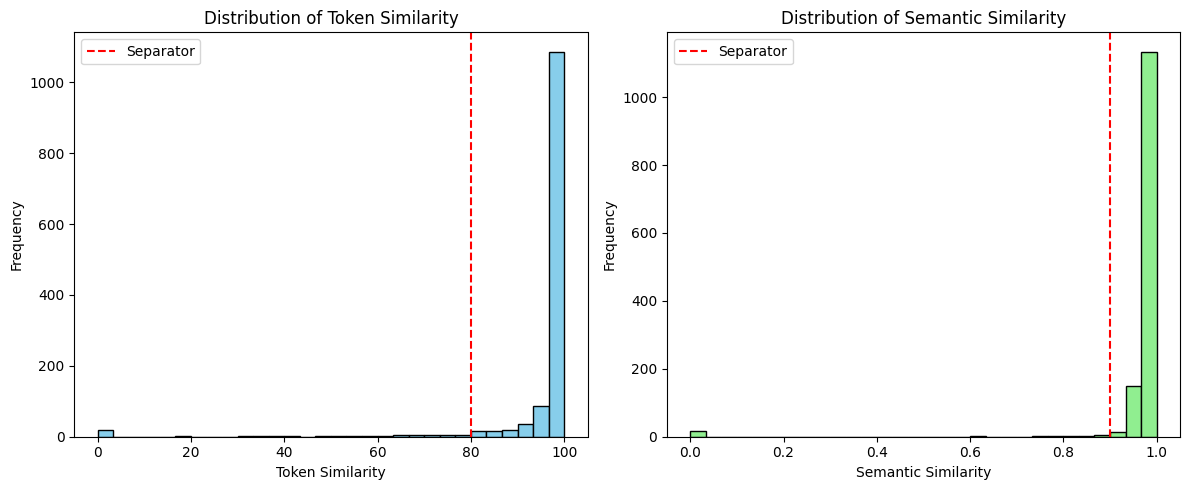

In [27]:
# Plot distributions
plt.figure(figsize=(12, 5))

# Token similarity histogram
plt.subplot(1, 2, 1)
plt.hist(file_df["Token Similarity"].dropna(), bins=30, color="skyblue", edgecolor="black")
plt.axvline(tok_sim_threshold, color="red", linestyle="--", label="Separator")
plt.title("Distribution of Token Similarity")
plt.xlabel("Token Similarity")
plt.ylabel("Frequency")
plt.legend()

# Semantic similarity histogram
plt.subplot(1, 2, 2)
plt.hist(file_df["Semantic Similarity"].dropna(), bins=30, color="lightgreen", edgecolor="black")
plt.axvline(sem_sim_threshold, color="red", linestyle="--", label="Separator")
plt.title("Distribution of Semantic Similarity")
plt.xlabel("Semantic Similarity")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.savefig("lab3_plots/histogram_similarities.png")
plt.show()

Classes Agree
YES    1289
NO       37
Name: count, dtype: int64

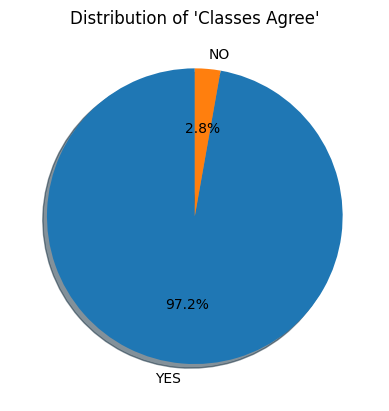

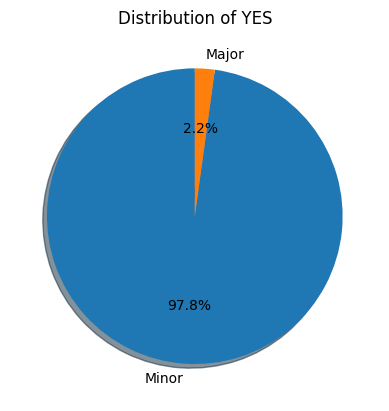

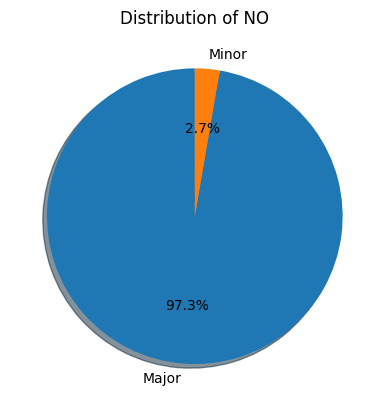

In [28]:
display(file_df['Classes Agree'].value_counts())
file_df['Classes Agree'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    shadow=True
)
plt.ylabel("") 
plt.title("Distribution of 'Classes Agree'")
plt.savefig("lab3_plots/pie_classes_agree.png")
plt.show()

file_df.loc[file_df['Classes Agree']=='YES', 'Token Class'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    shadow=True
)
plt.ylabel("") 
plt.title("Distribution of YES")
plt.savefig("lab3_plots/pie_yes.png")
plt.show()

file_df.loc[file_df['Classes Agree']=='NO', 'Token Class'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    shadow=True
)
plt.ylabel("") 
plt.title("Distribution of NO")
plt.savefig("lab3_plots/pie_no.png")
plt.show()